# Pertussis Manuscript Analysis

Configuring the pertussis RNA-seq analysis pipeline from the *Profiling of immune alterations in acellular and whole-cell vaccine-primed individuals after receiving Tdap booster vaccine* manuscript. This notebook was created using Python version 3.7.3.

## § 1: Setup

The following blocks will implement some optional Jupyter preferences, handle the imports needed for the analysis, define useful functions, and load the required data.

### § 1.1: Quality of Life Preferences (OPTIONAL)

In [1]:
# Jupyterthemes dark theme enabled. Revert to standard w/: jt -r
!jt -t chesterish

### § 1.2: Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import itertools
from  matplotlib.colors import LinearSegmentedColormap
from sklearn import decomposition
from sklearn.preprocessing import scale
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon, mannwhitneyu
from scipy.spatial import distance as spdist
import scipy.cluster.hierarchy as sch

from platform import python_version
print(python_version())

3.7.3


### § 1.3: Functions

In [3]:
# Define grids for plotting
def _grid_conf(n):
    if n==1:
        return 1, 1
    if n == 2:
        return 1, 2
    if n == 4:
        return 2, 2
    if n == 7:
        return 3, 4
    c = 0
    while c*(c+3)<n:
        c+=1
    return c, c+3

### § 1.4: Required Files

In [4]:
# Load and trim the WGCNA modules Dataframe
mdl_pc1 = pd.read_csv('Pertussis_data/modules.tsv', sep = '\t', index_col = 0)
mdl_pc1.index = list(map(lambda s: s[1:], mdl_pc1.index))
mdl_pc1.drop(["Cohort", "Visit"], axis='columns', inplace=True)
mdl_pc1.head()

,MEblue,MEmidnightblue,MEturquoise,MEmagenta,MEpurple,MEdarkturquoise,MEskyblue,MEdarkmagenta,MEorangered4,MElightcyan,...,MEgreenyellow,MEdarkred,MEdarkolivegreen,MEpaleturquoise,MEplum1,MEdarkorange,MEsienna3,MEgrey60,MEsaddlebrown,MEsteelblue
26_2686_1_TimePoint1,0.032572,0.059626,-0.003696,-0.049909,-0.087405,0.123718,0.107220,0.031622,0.032426,0.094021,...,0.095439,0.087437,0.142380,-0.011394,0.002363,-0.141727,-0.168045,-0.018405,-0.096459,-0.004736
27_2686_2_TimePoint2,0.038407,0.059687,0.010305,-0.032420,-0.075530,0.127211,0.112033,0.018541,0.033606,0.095528,...,0.097580,-0.015545,0.016799,-0.013672,-0.012921,-0.146348,-0.149503,-0.033809,-0.090561,-0.028669
28_2686_3_TimePoint3,0.039837,0.066291,0.017935,-0.037890,-0.101913,0.165659,0.158567,0.014088,0.034655,0.106157,...,0.139949,0.046571,0.097421,-0.002448,-0.004536,-0.183459,-0.197115,-0.038666,-0.134545,-0.019157
29_2686_4_TimePoint4,0.067749,0.062812,0.067663,0.023252,-0.046495,0.034712,0.075583,0.007085,0.026369,0.072887,...,0.010875,0.066752,-0.026853,-0.039986,-0.085195,-0.178945,-0.139115,-0.118297,-0.145884,-0.070540
30_2686_5_TimePoint5,0.021872,0.064915,-0.015452,-0.046948,-0.076163,0.043377,0.098884,0.073363,0.057984,0.107584,...,0.021974,-0.058603,-0.006209,-0.046504,-0.043819,-0.110387,-0.094859,-0.091306,-0.102001,-0.071577


In [5]:
# Load individual gene information (from modules)
modules_ginfo = pd.read_csv('Pertussis_data/modules_GeneInfo.tsv', sep = '\t', index_col = 0)
modules_ginfo.head()

,moduleColor,geneSig,moduleMembership,aP,wP,MM.white,MM.pink,MM.red,MM.plum1,MM.lightyellow,...,MM.saddlebrown,MM.steelblue,MM.royalblue,MM.yellowgreen,MM.sienna3,MM.darkred,MM.skyblue,MM.tan,MM.darkturquoise,MM.orangered4
ENSG00000150782.7,black,0.415730,0.370913,224.426854,155.881869,0.134655,0.158064,0.273631,0.538237,0.150667,...,-0.000852,-0.113326,-0.230134,-0.173531,-0.146748,0.142056,0.252213,0.134989,0.326358,-0.012320
ENSG00000196664.4,black,0.393809,0.783389,463.452329,283.841575,0.286501,0.286993,0.548794,0.446113,0.262809,...,-0.130339,-0.216950,-0.348061,-0.179376,-0.438973,0.045464,0.599073,0.398546,0.548223,0.166172
ENSG00000123685.4,black,0.390286,0.511968,95.751106,54.938307,0.215628,0.537952,0.605394,0.693409,0.554042,...,0.191428,0.015163,-0.033408,-0.254899,0.039578,0.139438,0.013095,-0.054063,0.131877,-0.292715
ENSG00000125384.6,black,0.389184,0.577166,1654.538039,1191.384627,0.228257,0.516840,0.574537,0.744241,0.549856,...,0.260864,0.126911,-0.049842,-0.273284,-0.005374,0.144001,0.114727,-0.013076,0.290167,-0.272951
ENSG00000180304.10,black,0.388709,0.709291,1776.121686,1431.366804,0.311950,0.459809,0.634672,0.731633,0.500077,...,0.165495,0.090590,-0.248518,-0.400623,-0.153274,0.170369,0.265755,0.050292,0.430741,-0.245365


In [6]:
# Load RNA-seq data and create some useful dictionaries
run3608tpm = pd.read_csv('Pertussis_data/run3608TPM.tsv', sep = '\t', index_col = 0)
gntypes = run3608tpm.groupby('gene_type').groups
gn2type = run3608tpm['gene_type'].to_dict()
gid2name = run3608tpm['alt_gene_name'].to_dict()
ensid2name = {ver.split('.')[0]:n for ver,n in gid2name.items()}
run3608tpm.drop(['gene_type', 'alt_gene_name'], axis='columns', inplace=True)

In [7]:
# Load the metadata
ptmetadata = pd.read_csv('Pertussis_data/pertussis_metadata.tsv',
                         sep='\t', index_col=3, converters={'subject':lambda s: str(s)})

In [8]:
# Visit to date
v2d = {n:a[0] for n, a in ptmetadata.groupby('visitN')['day_post_boost'].unique().items()}

### § 1.5: Dropped Samples due to Quality Control

From the original 198 samples, 18 were dropped by Marianna due to concerns over the quality of the RNAseq results. These 18 samples are listed below and are excluded moving forward in the analysis.

In [9]:
full_samples = ptmetadata.index
qc_samples = mdl_pc1.index
dropped = full_samples.difference(qc_samples)
list(dropped)

['10_2689_5_TimePoint5',
 '131_2890_1_TimePoint1',
 '132_2890_2_TimePoint2',
 '133_2890_3_TimePoint3',
 '134_2890_4_TimePoint4',
 '135_2890_5_TimePoint5',
 '161_2922_1_TimePoint1',
 '162_2922_2_TimePoint2',
 '163_2922_3_TimePoint3',
 '164_2922_4_TimePoint4',
 '165_2922_5_TimePoint5',
 '196_2887_1_TimePoint1',
 '197_2887_2_TimePoint2',
 '198_2887_3_TimePoint3',
 '6_2689_1_TimePoint1',
 '7_2689_2_TimePoint2',
 '8_2689_3_TimePoint3',
 '9_2689_4_TimePoint4']

With all the necessary data loaded, now add to the gene information table and create our own modules 

## § 2: Analysis

### § 2.1: Run PCA and Update Gene Information

In [10]:
# Use the newly generated dictionaries to update gene information
modules_ginfo['gene_name'] = [gid2name[g] for g in modules_ginfo.index]
modules_ginfo['ensembl_id'] = [g.split('.')[0] for g in modules_ginfo.index]

# Add module sizes to our gene information
modules_ginfo['clustersize'] = 0
for i, idx in modules_ginfo.groupby('moduleColor').groups.items():
    modules_ginfo.loc[idx, 'clustersize'] = len(idx)
    
# Generate the PC1 dataframe from the RNAseq data
rnaseq_mdl_pc1 = mdl_pc1.copy()
rnaseq_mdl_pc1[:] = np.nan

samps = rnaseq_mdl_pc1.index
for mdl in rnaseq_mdl_pc1.columns:
    gg = modules_ginfo[modules_ginfo.moduleColor==mdl[2:]].index
    scaled = scale(run3608tpm.loc[gg, samps].values.T, with_mean=True, with_std=True)
    pca = decomposition.PCA()
    pca.fit(scaled)
    pcs = pca.transform(scaled)
    rnaseq_mdl_pc1.loc[samps, mdl] = pcs[:,0]

In [11]:
# Change the module names
# For manuscript the clusters will be names TrCXX instead of color names 
# produced by WGCNA
modules_ginfo['cluster'] = ['ME'+c for c in modules_ginfo['moduleColor']]
c2d = {}
modules_ginfo.sort_values('clustersize', ascending=False, inplace=True)
modules_ginfo['cluster_mns'] = ['TrC{:02d}'.format(c2d.setdefault(c, len(c2d)+1)) for c in modules_ginfo.moduleColor]
wgcna_mdl_nm = dict(modules_ginfo.set_index('cluster')['cluster_mns'].items())

### § 2.2: Find Perturbations within Gene Modules

We need to find clusters which are perturbed throughout the course of observation. To do so two criteria are introduced:

1. **Statistical significance**. should be a strong significance (by unparametric Wilcoxon test) of difference between the highest and the lowest (from 0,1,3,7,14 days after vaccination) points of PC1.

2. **Magnitude of perturbation** . When the highest and lowest points are picked then the difference of median at this points is compared to inter-individual variability at these two points. More precisely 10th and 90th percentile is used because is less sensitive to outliers.

Also is done on all donors, wP and aP only. Perturbed are those which are perturbed in at least 1 of the 3.

In [12]:
mdata = ptmetadata.loc[rnaseq_mdl_pc1.index]
 
pvals = {grp:pd.DataFrame(index=rnaseq_mdl_pc1.columns, columns=pd.MultiIndex.from_tuples(itertools.combinations(range(1,6), 2))) for grp in ('all', 'wP', 'aP')}
stats = {grp:pd.DataFrame(index=rnaseq_mdl_pc1.columns, columns=pd.MultiIndex.from_tuples(itertools.combinations(range(1,6), 2))) for grp in ('all', 'wP', 'aP')}
 
subjects = {}
subjects['all'] = list(set(mdata.subject))
for cohort in 'wP', 'aP':
    subjects[cohort] = list(set(mdata[mdata.cohort==cohort].subject))
 
for mdl in rnaseq_mdl_pc1.columns:
    for grp in pvals:
        def _key_func(t):
            tsamps = mdata[mdata.visitN==t].reset_index().set_index('subject').loc[subjects[grp]]['index']
            return rnaseq_mdl_pc1.loc[tsamps, mdl].median()
        
        tmhi = max(range(2,6), key=_key_func)
        tmlo = min(range(1,6), key=_key_func)
 
        hisamps = mdata[mdata.visitN==tmhi].reset_index().set_index('subject').loc[subjects[grp]]['index']
        losamps = mdata[mdata.visitN==tmlo].reset_index().set_index('subject').loc[subjects[grp]]['index']
         
        assert len(hisamps) == len(losamps)
         
        stat, pval = wilcoxon(rnaseq_mdl_pc1.loc[hisamps, mdl], rnaseq_mdl_pc1.loc[losamps, mdl])    
        
        mx = np.percentile(np.append(rnaseq_mdl_pc1.loc[hisamps, mdl].values, rnaseq_mdl_pc1.loc[losamps, mdl].values), 90)
        mn = np.percentile(np.append(rnaseq_mdl_pc1.loc[hisamps, mdl].values, rnaseq_mdl_pc1.loc[losamps, mdl].values), 10)
        pvals[grp].loc[mdl, tuple(sorted([tmhi, tmlo]))] = pval
        stats[grp].loc[mdl, tuple(sorted([tmhi, tmlo]))] = (rnaseq_mdl_pc1.loc[hisamps, mdl].mean()-rnaseq_mdl_pc1.loc[losamps, mdl].mean()) / (mx-mn)
 
corrected = {}
for grp in pvals:
    df = pvals[grp].copy()
    mask = -df.isna()
    _uncorrected = df.values[mask]
    _corrected = fdrcorrection(_uncorrected)[1]
    df.values[mask] = _corrected
    corrected[grp] = df
 
perturbed = set()
for grp in pvals:
    _pt = corrected[grp][(corrected[grp]<0.01).any(axis=1)].index\
              .intersection(stats[grp][(stats[grp].abs()>0.20).any(axis=1)].index)
    perturbed = perturbed.union(_pt)

### § 2.3: Create Dendrogram to find Module Clusters

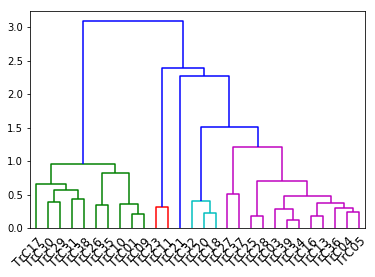

In [13]:
mdata = ptmetadata.loc[rnaseq_mdl_pc1.index]
 
cltr_nm = dict(modules_ginfo.set_index('cluster')['cluster_mns'].items())
 
pc1mn = pd.DataFrame(index=list(perturbed),
                       columns=list(range(1,6)))
 
for visitN in pc1mn.columns:
    samps = mdata[mdata.visitN==visitN].index
    for cltr in pc1mn.index:
        pc1mn.loc[cltr, visitN] = rnaseq_mdl_pc1.loc[samps, cltr].mean()
 
data = pc1mn.subtract(pc1mn.mean(axis=1), axis=0).divide(pc1mn.max(axis=1) - pc1mn.min(axis=1), axis=0)

D = spdist.pdist(data.values, metric='cityblock')
Y = sch.linkage(D, method='average')
 
# this threshold is manually picked just to represent 
# visual identification of clusters
thr=0.4
plt.clf()
ax = plt.gca()
Z = sch.dendrogram(Y, color_threshold=thr*max(Y[:,2]),
                   count_sort='ascending', leaf_font_size=12,
                   leaf_label_func=lambda i: cltr_nm[data.index[i]])
 
for lbl in ax.get_xticklabels():
    lbl.set_rotation(45)
    lbl.set_horizontalalignment('right')
    lbl.set_rotation_mode('anchor')
 
fc = sch.fcluster(Y, t=thr*max(Y[:,2]), criterion='distance')

### § 2.4: Create Clusters from Dendrogram Results

In [14]:
# Create reference dict for the dendrogram groupings above
wgcna_grp = dict(zip(data.index, fc))
wgcna_grp_inv = {}
for cltr, grp in wgcna_grp.items():
    wgcna_grp_inv.setdefault(grp, []).append(cltr)
wgcna_grp_inv['unperturbed'] = list(set(modules_ginfo['cluster']).difference(wgcna_grp))
modules_ginfo['cluster_group'] = [wgcna_grp.get(m, '') for m in modules_ginfo['cluster']]

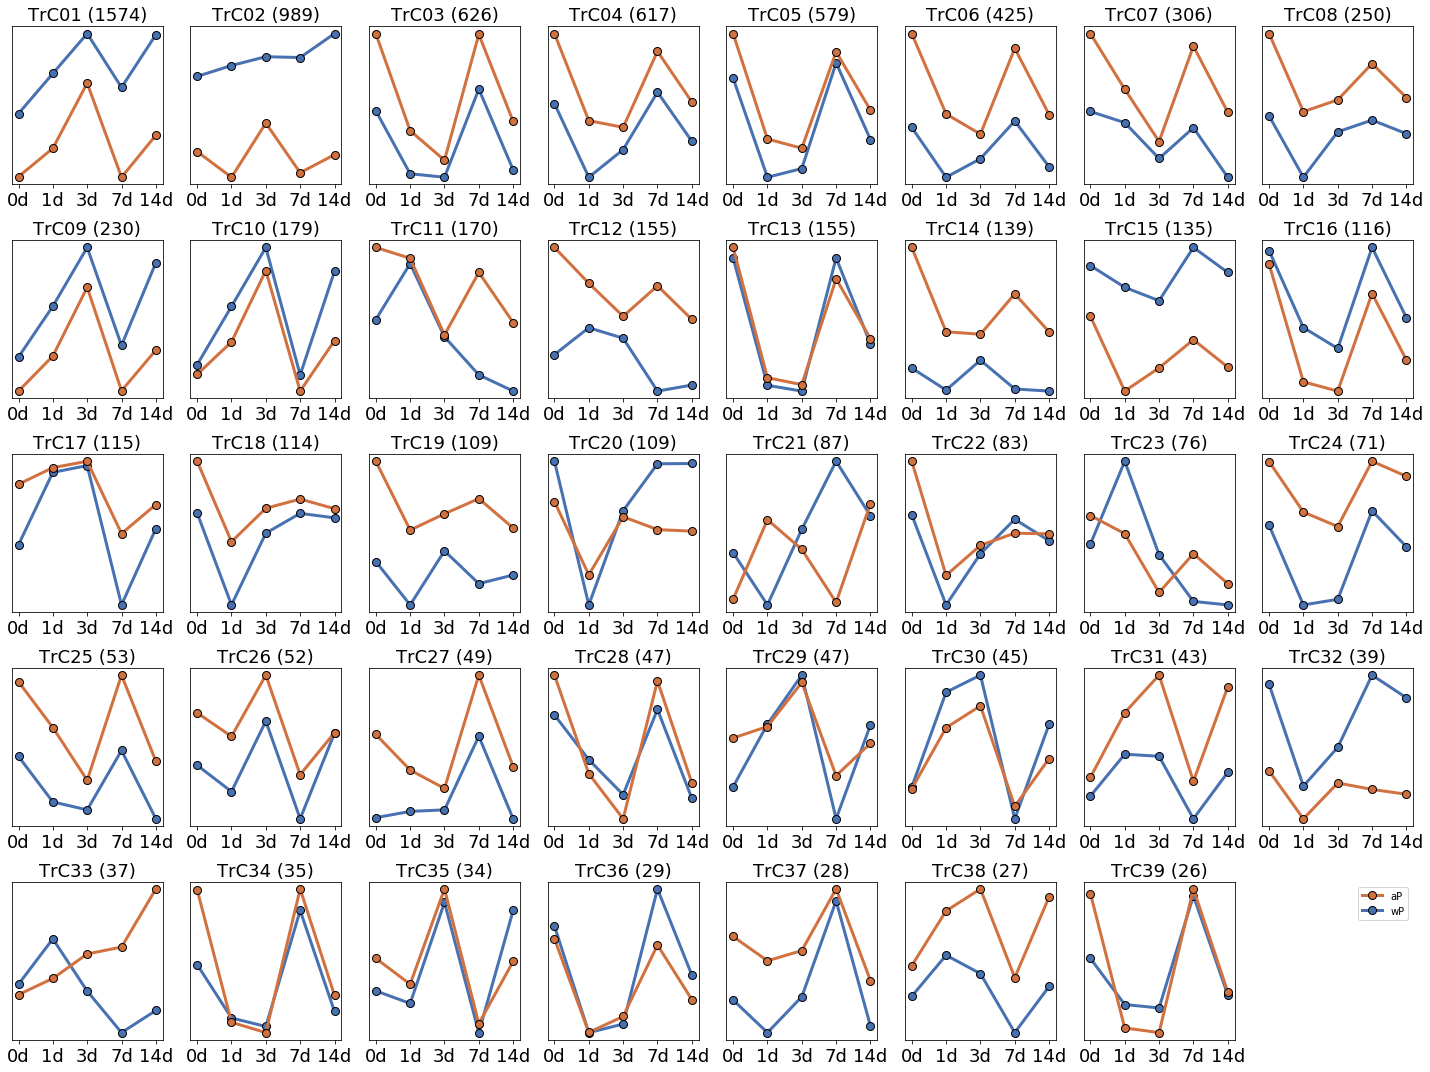

In [15]:
rnaseq_data = rnaseq_mdl_pc1
mdldata = modules_ginfo
mdlnames = dict(mdldata.set_index('cluster')['cluster_mns'].items())
mdlsizes = dict(mdldata.set_index('cluster')['clustersize'].items())
 
mdata = ptmetadata.loc[rnaseq_data.index]
grpd = mdata.groupby(['cohort', 'visitN'])
 
colors = {'wP':'#4771b1', 'aP':'#d27140'}
 
plt.clf()
cnt = 0

mdl2plot = rnaseq_data.columns
 
lgnd = {}
for mdl in sorted(mdl2plot, key=lambda m: mdlnames[m]):
    cnt += 1
    ax = plt.subplot(*_grid_conf(len(mdl2plot)+1), cnt)
    for cohort in set(mdata.cohort):
        color = colors[cohort]
        pc1 = {}
        for T in range(1, 6):
            samps = mdata[(mdata.cohort==cohort)&(mdata.visitN==T)].index
            pc1[T] = rnaseq_data.loc[samps, mdl].mean()
             
        art = ax.plot(np.arange(5), [pc1[t] for t in range(1,6)], #markerfacecolor='black',
                      markeredgecolor='black', c=color,
                      linewidth=3, markersize=8, marker='o')
        lgnd[cohort] = art[0]
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(['0d', '1d', '3d', '7d', '14d'], fontsize=18)
    ax.set_yticks([])
    ax.set_title('{:s} ({:d})'.format(mdlnames[mdl], mdlsizes[mdl]),
                 fontsize=18)
 
lgd_ax = plt.subplot(*_grid_conf(len(mdl2plot)+1), cnt+1)
lgd_ax.legend((lgnd['aP'], lgnd['wP']), ('aP', 'wP'))
lgd_ax.set_xticks([])
lgd_ax.set_yticks([])
lgd_ax.set_frame_on(False)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig = plt.gcf()
fig.set_size_inches(20,15)
plt.tight_layout()

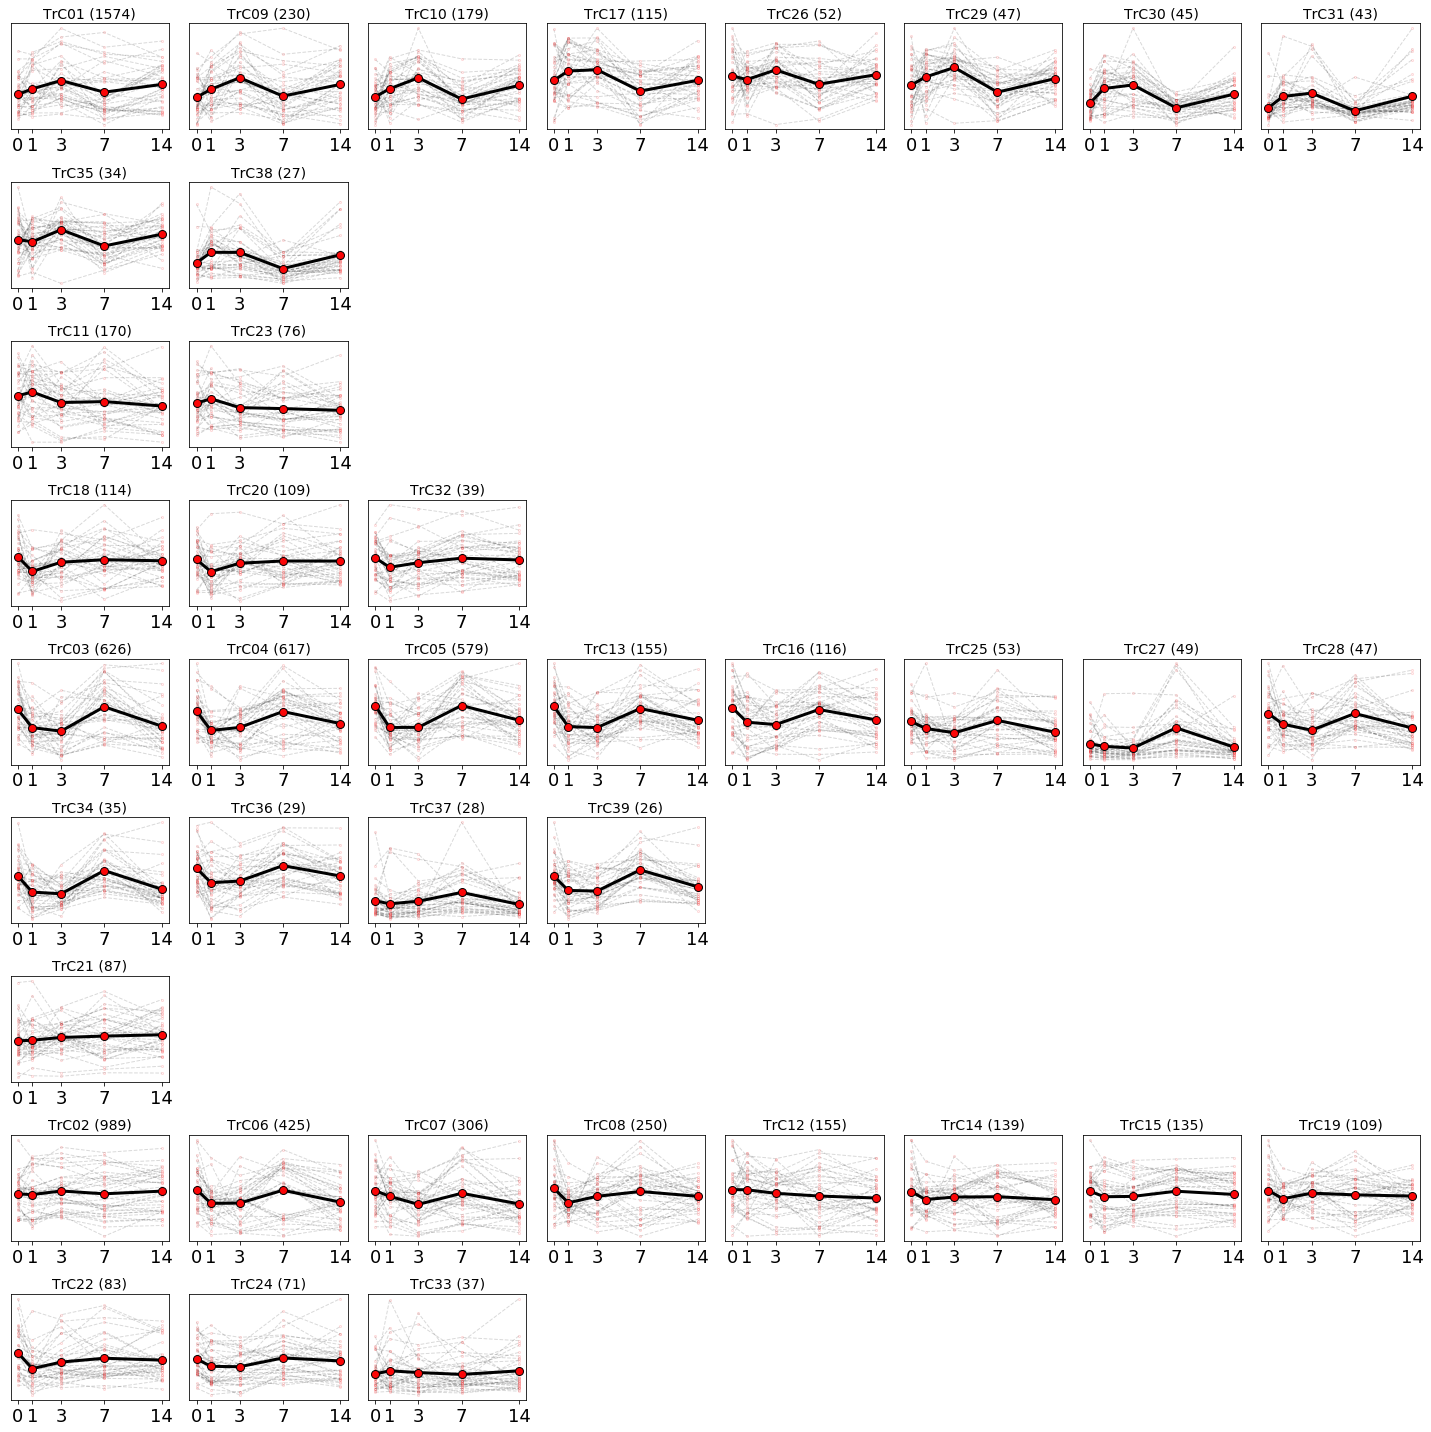

In [16]:
scld_rng = [0, 1, 3, 6, 10]
mdlnames = dict(modules_ginfo.set_index('cluster')['cluster_mns'].items())
mdlsizes = dict(modules_ginfo.set_index('cluster')['clustersize'].items())
 
mdata = ptmetadata.loc[rnaseq_mdl_pc1.index]
grpd = mdata.groupby(['cohort', 'visitN'])
 
colors = {'wP':'#4771b1', 'aP':'#d27140'}
 
grd_conf = (9,8)
 
plt.clf()
cnt = 1
for cltr_grp in (1, 2, 3, 4, 5, 'unperturbed'):
    cltrs = wgcna_grp_inv[cltr_grp]
    while cnt % grd_conf[1] != 1:
        cnt += 1
 
    for mdl in sorted(cltrs, key=lambda c: int(mdlnames[c][3:])):
        ax = plt.subplot(*grd_conf, cnt)
        for donor in set(mdata.subject):
            samps = mdata[mdata.subject==donor].sort_values('visitN').index
            marker = 'o'; lw=1.0; ms = 2
            ax.plot(scld_rng, rnaseq_mdl_pc1.loc[samps, mdl],
                    markerfacecolor='white', markeredgecolor='#fb0607', markeredgewidth=1.0,
                    markersize=ms, 
                    color='black',
                    linestyle='--', marker=marker, linewidth=lw, alpha=.15)
        mn = {}
        for visitN in range(1,6):
            mn[visitN] = rnaseq_mdl_pc1.loc[mdata[mdata.visitN==visitN].index, mdl].mean() 
        art = ax.plot(scld_rng, [mn[t] for t in range(1,6)], c='black',
                      markeredgecolor='black',markerfacecolor='#fb0607',
                      linestyle='-', linewidth=3, marker='o', markersize=8)
 
        ax.set_xticks(scld_rng)
        ax.set_xticklabels(['0', '1', '3', '7', '14'], fontsize=18)
        ax.set_yticks([])
        ax.set_title('{:s} ({:d})'.format(mdlnames[mdl], mdlsizes[mdl]),
                     fontsize=14)
        cnt += 1
 
#plt.subplots_adjust(wspace=0.1, hspace=0.2)
fig = plt.gcf()
fig.set_size_inches(20,20)
plt.tight_layout()

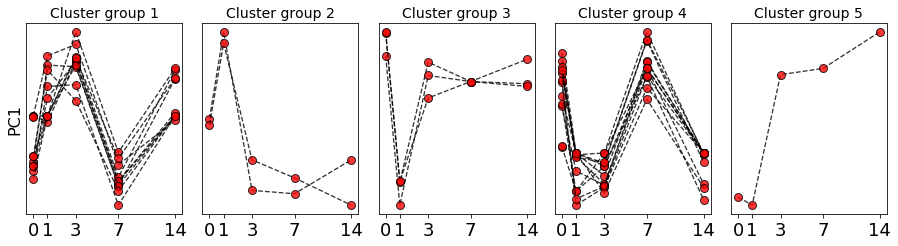

In [17]:
scld_rng = [0, 1, 3, 6, 10]
mdlnames = dict(modules_ginfo.set_index('cluster')['cluster_mns'].items())
mdlsizes = dict(modules_ginfo.set_index('cluster')['clustersize'].items())
 
mdata = ptmetadata.loc[rnaseq_mdl_pc1.index]
 
#grd_conf = (1, 4)
grd_conf = (1,5)
 
plt.clf()
fig = plt.gcf()
fig.set_size_inches([12.6 ,  3.53])
 
cnt = 1
for cltr_grp in (1, 2, 3, 4, 5):
#for cltr_grp in (1, 2, 5, 3, 4):
    ax = plt.subplot(*grd_conf, cnt)
     
    cltrs = wgcna_grp_inv[cltr_grp]
    for cltr in cltrs:
        dt = mdata.copy()
        dt['mdl'] = rnaseq_mdl_pc1.loc[dt.index, cltr]
        dt = dt.reset_index().set_index(['subject', 'visitN'])
        mdn = dt['mdl'].median(level=1)
        mdn = mdn.subtract(mdn.median()).divide(mdn.max()-mdn.min())
         
        ax.plot(scld_rng, mdn, 
                markerfacecolor='#fb0607', markeredgecolor='black', markeredgewidth=1.0,
                markersize=8, 
                color='black',
                linestyle='--', marker='o', linewidth=1.3, alpha=.8)
 
    if cnt == 1:
        ax.set_ylabel('PC1', fontsize=16)
    ax.set_xticks(scld_rng)
    ax.set_xticklabels(['0', '1', '3', '7', '14'], fontsize=18)
    ax.set_yticks([])
    ax.set_title('Cluster group {:d}'.format(cnt),
                 fontsize=14)
    cnt += 1
 
#plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.tight_layout()
plt.savefig('Output/Figure2.png', dpi=300, facecolor=fig.get_facecolor())

### § 2.x: Plotting IgH Expression

36

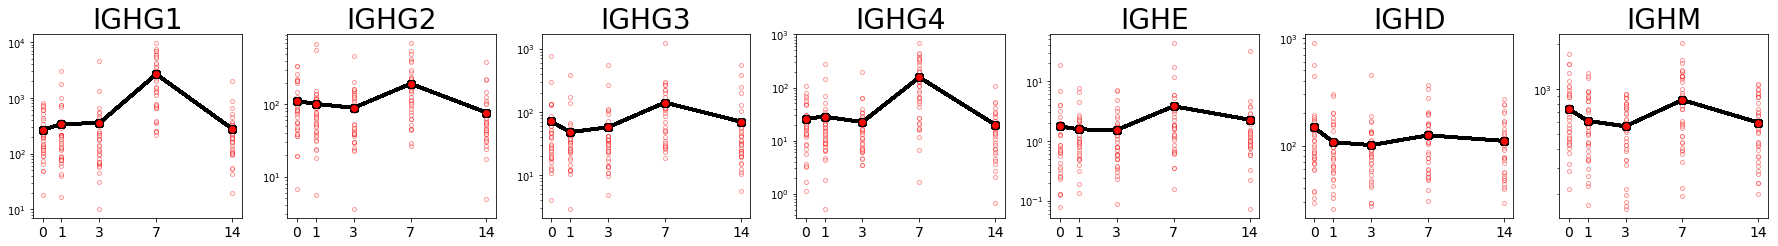

In [30]:
ighg = {}
ighg[1] = 'ENSG00000211896.2'
ighg[2] = 'ENSG00000211893.3'
ighg[3] = 'ENSG00000211897.3'
ighg[4] = 'ENSG00000211892.2'
ighe = 'ENSG00000211891.4'
ighd = 'ENSG00000211898.3'
ighm = 'ENSG00000211899.3'

gg = list(ighg.values())+[ighe, ighd, ighm]
scld_rng = [0, 1, 3, 6, 10]
 
mdata = ptmetadata.loc[mdl_pc1.index]
colors = {'wP':'#4771b1', 'aP':'#d27140'}
 
plt.clf()
fig = plt.gcf()
fig.set_size_inches([24.8, 3.53])
fig.set_facecolor((0.0, 0.0, 0.0, 0.0))

grd_conf = (1,7)
 
cnt = 1
lgnd = {}
for gid in gg:
    ax = plt.subplot(*grd_conf, cnt)
    ax.set_facecolor('white')
    for visitN, T in zip(range(1,6), scld_rng):
        samps = mdata[(mdata.visitN==visitN)].index
        ax.plot([T]*len(samps), run3608tpm.loc[gid, samps],
                    marker='o', 
                    markersize=4, markeredgecolor='#fb0607',
                    markeredgewidth=1.0,
                    markerfacecolor='white', linestyle='',
                    alpha=0.4)
        dt[T] = run3608tpm.loc[gid, samps].mean()
    art = ax.plot(scld_rng, [dt[t] for t in scld_rng], c='black',
                  markeredgecolor='black', markerfacecolor='#fb0607',
                  markersize=8, linewidth=3, marker='o')
    ax.set_xticks(scld_rng)
    ax.set_xticklabels(['0', '1', '3', '7', '14'], fontsize=14)
    ax.set_title(gid2name[gid], fontsize=28)
    ax.set_yscale('log')
    
    cnt+=1

lgd_ax.set_frame_on(False)
lgd_ax.set_xticks([])
lgd_ax.set_yticks([])

plt.subplots_adjust(wspace=0.22, hspace=0.4)
plt.tight_layout()
plt.savefig('Output/Figure5A_combined.png', dpi=250, facecolor=fig.get_facecolor())

display(len(samps))

### § 2.5: Create Table of Wilcoxon P-Values
For each transcriptional module (TrC1 - TrC39), I have already found the timepoint of highest expression (tmhi) and the timepoint of lowest expression (tmlo). Using these two timepoints, a paired non-parametric Wilcoxon test was used to determine if the difference between the medians/distributions of the two was significant. This was done for the entire cohort (aP & wP), for just aP, and for just wP. The resulting p-values are listed below.

In [19]:
pval_table = {}
for grp in corrected:
    pval_df = corrected[grp].copy()
    p_mask = -pval_df.isna()
    vals = pval_df.values[p_mask]
    pval_table[grp] = vals

# Convert to DataFrame and set WGCNA module names to TrC names
pvalues = pd.DataFrame(pval_table, index=[wgcna_mdl_nm[x] for x in corrected['all'].index])
pvalues = pd.DataFrame.sort_index(pvalues)

# Create csv file
#pd.DataFrame.to_csv(pvalues, 'TrC_Wilcoxon_Pvalues.csv')

In [20]:
#* Per timepoint test #rnaseq_mdl*_pc1
rnaseq_data = rnaseq_mdl_pc1
 
mdata = ptmetadata.loc[rnaseq_data.index]
res = pd.DataFrame(index=rnaseq_data.columns, columns=[1,2,3,4,5])
 
for tm in res.columns:
    ap = mdata[(mdata.visitN==tm)&(mdata.cohort=='aP')].index
    wp = mdata[(mdata.visitN==tm)&(mdata.cohort=='wP')].index
    for mdl in res.index:
        pval = mannwhitneyu(rnaseq_data.loc[ap, mdl], rnaseq_data.loc[wp, mdl], alternative='two-sided').pvalue
        res.loc[mdl, tm] = pval
 
res.columns = [v2d[c] for c in res.columns]
 
corrected = res.copy()
for tm in res.columns:
    corrected[tm] = fdrcorrection(res[tm])[1]
#corrected[corrected>0.05] = 1
 
corrected137 = res[['1d', '3d', '7d']].copy()
corrected137[:] = fdrcorrection(corrected137.values.flatten())[1].reshape(corrected137.shape)
#corrected137[corrected137>0.05] = 1

corrected137['TrC'] = corrected137.index.map(wgcna_mdl_nm)
cols = list(corrected137.columns)
cols = [cols[-1]] + cols[:-1]
corrected137 = corrected137[cols]

corrected['TrC'] = corrected.index.map(wgcna_mdl_nm)
cols = list(corrected.columns)
cols = [cols[-1]] + cols[:-1]
corrected = corrected[cols]

pd.DataFrame.to_csv(corrected137, 'Output/mannwhitney_pvals_137.csv')
pd.DataFrame.to_csv(corrected, 'Output/mannwhitney_pvals_all.csv')

### § 2.6: Create Heatmap of 15 DEGs at Day 7

<Figure size 432x288 with 0 Axes>

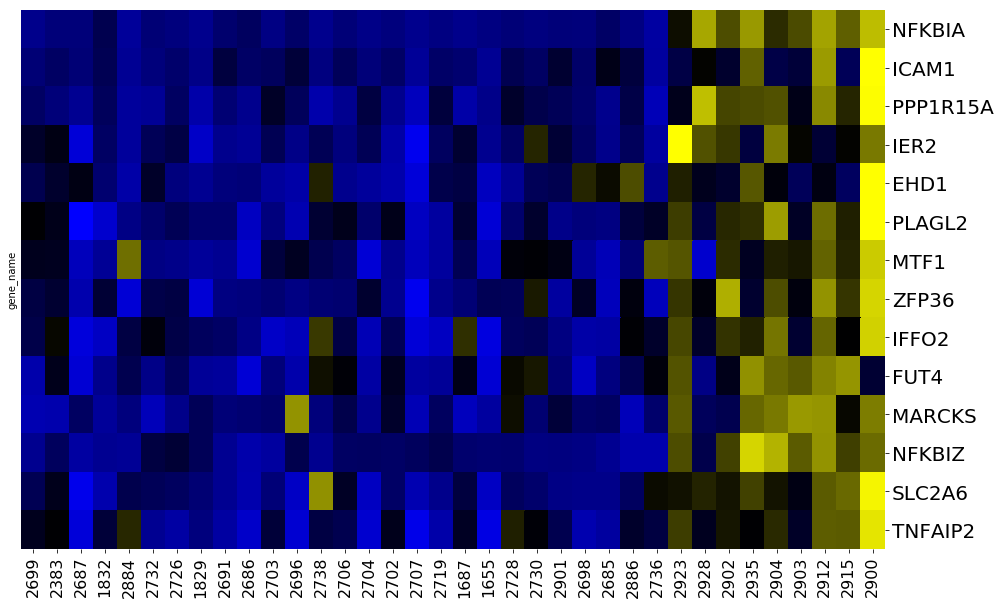

In [21]:
c = ['blue','black','yellow']
v = [0,.5,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('yb',l, N=256)

selected_genes = ["ENSG00000100906.6", "ENSG00000090339.4", "ENSG00000087074.7", "ENSG00000160888.6", "ENSG00000110047.13", "ENSG00000126003.6", "ENSG00000188786.9", "ENSG00000128016.4", "ENSG00000169991.6", "ENSG00000196371.2", "ENSG00000155130.5", "ENSG00000144802.7", "ENSG00000160326.9", "ENSG00000185215.4"]
data = run3608tpm.loc[selected_genes]
data = data.filter(regex='TimePoint4')
for smpl in list(dropped):
    if smpl in data.columns:
        data.drop(smpl, axis=1, inplace=True)

ap = []
wp = []
for smpl in data.columns:
    if mdata.loc[smpl].cohort=='aP':
        ap.append(smpl)
    else:
        wp.append(smpl)
ap_order = [7,2,3,4,5,6,8,1,15,14,0,9,10,11,12,13]
ap_ordered = [ap[i] for i in ap_order]
ap_ordered.reverse()
cohort = wp + ap_ordered
#cohort = ap + wp
data = data.reindex(columns=cohort)

data = data.subtract(data.mean(axis=1), axis=0).divide(data.std(axis=1), axis=0)
data.clip(upper=3.0, lower=-3, inplace=True)

collbl = [str(mdata.loc[s, 'subject'])  for s in data.columns]
rowlbl = ['' if g.startswith('delim') else ensid2name[g.split('.')[0]] for g in data.index]
 
plt.clf()
fig = plt.gcf()
f = plt.figure(figsize=(14,8.5))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
g = sb.heatmap(data, cmap=cmap, cbar=False,
              xticklabels=collbl,
              yticklabels=rowlbl)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 16)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 20)
plt.tight_layout()
plt.savefig('Output/Day7Heatmap.png', dpi=250, facecolor=fig.get_facecolor())

In [26]:
## IGNORE ##
# Store data for use in Figure 4 (done in CyTOF notebook)
%store wgcna_mdl_nm
%store rnaseq_mdl_pc1

Stored 'wgcna_mdl_nm' (dict)
Stored 'rnaseq_mdl_pc1' (DataFrame)
